In [1]:
from lbmpy.session import *
from lbmpy.relaxationrates import *
from lbmpy.methods.momentbasedsimplifications import cse_in_opposing_directions
from lbmpy.turbulence_models import add_smagorinsky_model

# Printing Moment tables

In [ ]:
def to_latex(method):
    result = "Moment & Equilibrium & Relaxation rate \\\\ \hline \n"
    for moment, (eq_moment, rr) in method.relaxation_info_dict.items():
        line = " & ".join("$" + sp.latex(r) + "$" for r in (moment, eq_moment, rr))
        result += line + "  \\\\ \n"
    return result

In [ ]:
method = create_lb_method(method='mrt', weighted=True, compressible=False)
print(to_latex(method))

In [ ]:
method

# Smagorinsky

In [ ]:
S, C_S, ν_0, τ_0, ω, Π, ω_0 = sp.symbols("|S|, C_S, ν_0, τ_0, ω, |Π|, ω_0", positive=True)

## Direct solution

Assuming one knows S, compute ω

In [ ]:
#effective_ν_from_S = ν_0 + C_S ** 2 * S
effective_ν_from_S = lattice_viscosity_from_relaxation_rate(ω_0) + C_S ** 2 * S
ω_val = relaxation_rate_from_lattice_viscosity(effective_ν_from_S)
omega_eq = sp.Eq(ω, ω_val)
omega_eq

Defining equation for S

In [ ]:
defining_eq_s = sp.Eq(S, 3 * ω / 2 * Π)
defining_eq_s

Directly solving the system does not work

In [ ]:
solve_res = sp.solve([defining_eq_s, omega_eq], [ω, S], dict=True)
solve_res[0]

# waLBerla approach

In [ ]:
factor = 18 * sp.sqrt( 2) * C_S * C_S;
walberla_τ_t =  ( sp.sqrt( τ_0 * τ_0 + factor * Π ) - τ_0 ) / 2
walberla_τ_t

Effective ω in waLBerla

In [ ]:
sp.simplify(1 / (τ_0 + walberla_τ_t))

# TRT simplification

Data for first table

In [ ]:
method = create_lb_method(method="srt", stencil="D3Q19", compressible=True, 
                          maxwellian_moments=False,
                         )
collision_rule = method.get_collision_rule()

generic_strategy = ps.simp.SimplificationStrategy()
generic_strategy.add(ps.simp.sympy_cse)
generic_strategy.create_simplification_report(collision_rule)

In [ ]:
simplification_strategy = create_simplification_strategy(method, cse_pdfs=False, cse_global=True)
simplification_strategy.create_simplification_report(collision_rule)

In [ ]:
t = {'stencil': 'D3Q19', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False, 'smagorinsky': True}
ur = create_lb_update_rule(**t)
ur.operation_count

## Simplification FLOP table SRT/TRT/Smag

In [ ]:
fixed_rates =[1.5, 1.4, 1.3, 1.2, 1.6, 1.9, 1.1, 1.0, 1.2, 1.8, 1.9, 1.23,
              1.5, 1.4, 1.3, 1.2, 1.6, 1.9, 1.1, 1.0, 1.2, 1.8, 1.9, 1.23,
              1.5, 1.4, 1.3, 1.2, 1.6, 1.9, 1.1, 1.0, 1.2, 1.8, 1.9, 1.23]
srt_trt_specs = [
    ('D2Q9 compr. SRT',         {'stencil': 'D2Q9', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False}),
    ('D2Q9 incompr. SRT',       {'stencil': 'D2Q9', 'method': 'srt', 'compressible': False, 'maxwellian_moments': False}),
    ('D2Q9 compr. Smag.',       {'stencil': 'D2Q9', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False, 'smagorinsky': True}),
    ('D2Q9 compr. TRT',         {'stencil': 'D2Q9', 'method': 'trt', 'compressible': True, 'maxwellian_moments': False}),
    ('D2Q9 incompr. TRT',       {'stencil': 'D2Q9', 'method': 'trt', 'compressible': False, 'maxwellian_moments': False}),
    ('D2Q9 MRT compr. weighted',{'stencil': 'D2Q9', 'method': 'mrt', 'compressible': True, 'weighted': True}),
    ('D2Q9 MRT compr.',         {'stencil': 'D2Q9', 'method': 'mrt', 'compressible': True, 'weighted': False}),

    
    ('D3Q19 compr. SRT',         {'stencil': 'D3Q19', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False}),
    ('D3Q19 incompr. SRT',       {'stencil': 'D3Q19', 'method': 'srt', 'compressible': False, 'maxwellian_moments': False}),
    ('D3Q19 compr. Smag.',       {'stencil': 'D3Q19', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False, 'smagorinsky': True}),
    ('D3Q19 compr. TRT',         {'stencil': 'D3Q19', 'method': 'trt', 'compressible': True, 'maxwellian_moments': False}),
    ('D3Q19 incompr. TRT',       {'stencil': 'D3Q19', 'method': 'trt', 'compressible': False, 'maxwellian_moments': False}),
    ('D3Q19 MRT compr. weighted',{'stencil': 'D3Q19', 'method': 'mrt', 'compressible': True, 'weighted': True}),
    ('D3Q19 MRT compr. ',        {'stencil': 'D3Q19', 'method': 'mrt', 'compressible': True, 'weighted': False}),

    ('D3Q27 compr. SRT',   {'stencil': 'D3Q27', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False}),
    ('D3Q27 incompr. SRT', {'stencil': 'D3Q27', 'method': 'srt', 'compressible': False,'maxwellian_moments': False}),
    ('D3Q27 compr. Smag.', {'stencil': 'D3Q27', 'method': 'srt', 'compressible': True, 'maxwellian_moments': False, 'smagorinsky': True}),
    ('D3Q27 compr. TRT',   {'stencil': 'D3Q27', 'method': 'trt', 'compressible': True, 'maxwellian_moments': False}),
    ('D3Q27 incompr. TRT', {'stencil': 'D3Q27', 'method': 'trt', 'compressible': False, 'maxwellian_moments': False}),
    ('D3Q27 MRT compr. weighted', {'stencil': 'D3Q27', 'method': 'mrt', 'compressible': True, 'weighted': True}),
    ('D3Q27 MRT compr. ',         {'stencil': 'D3Q27', 'method': 'mrt', 'compressible': True, 'weighted': False}), 

]

In [ ]:
def oc(m):
    return sum(i for i in m.operation_count.values())

print("            & Only CSE  & cse_pdfs  & cse_global \\\\ \\hline")
for name, spec in srt_trt_specs:
    method = create_lb_method(**spec)
    collision_rule = method.get_collision_rule()
    
    def add_tm(cr):
        if 'smagorinsky' in spec and spec['smagorinsky']:
            return add_smagorinsky_model(cr, 0.12)
        else:
            return cr
    
    cse_global = ps.simp.SimplificationStrategy()
    cse_global.add(ps.simp.sympy_cse)
    
    cse_both = ps.simp.SimplificationStrategy()
    cse_both.add(cse_in_opposing_directions)
    cse_both.add(ps.simp.sympy_cse)
    
    custom_opt = create_simplification_strategy(method, cse_pdfs=False, cse_global=False)
    
    generic_res           = oc(cse_global(add_tm(collision_rule)))
    custom_res_global_cse = oc(cse_both(add_tm(custom_opt(collision_rule))))
    custom_res_both_cse   = oc(cse_global(add_tm(custom_opt(collision_rule))))
    
    all_res = (generic_res, custom_res_global_cse, custom_res_both_cse)
    
    def t(r):
        return str(r) if r != min(all_res) else f"\\textbf{{{r}}}"

    print(f"{name}  &  {t(generic_res)}  & {t(custom_res_both_cse)}  & {t(custom_res_global_cse)} \\\\")

## MRT simplification

In [ ]:
from pystencils.simp import SimplificationStrategy
from lbmpy.methods.momentbased import MomentBasedLbMethod
from lbmpy.methods.momentbasedsimplifications import replace_second_order_velocity_products, \
    factor_density_after_factoring_relaxation_times, factor_relaxation_rates, cse_in_opposing_directions, \
    replace_common_quadratic_and_constant_term, replace_density_and_velocity

from lbmpy.innerloopsplit import create_lbm_split_groups
from lbmpy.methods.cumulantbased import CumulantBasedLbMethod
from pystencils.simp import (
    add_subexpressions_for_divisions, apply_to_all_assignments,
    subexpression_substitution_in_main_assignments, sympy_cse)

In [ ]:
method = create_lb_method(stencil="D3Q19", method="mrt", compressible=True)
cr = method.get_collision_rule()
cr_cse_global_adv = sympy_cse(subexpression_substitution_in_main_assignments(cr))
cr_cse_global_default = sympy_cse(cr)
cr_cse_pdfs = cse_in_opposing_directions(cr)

In [ ]:
set(create_lb_method().relaxation_rates)

In [ ]:
cr_cse_global_adv.operation_count, cr_cse_global_default.operation_count

In [ ]:
cr_cse_global_adv

In [ ]:
cr_cse_global = create_lbm_split_groups(cr_cse_global_adv)
cr_cse_pdfs = create_lbm_split_groups(cr_cse_pdfs)

In [ ]:
cr_cse_global.simplification_hints['split_groups']

In [ ]:
cr_cse_pdfs.simplification_hints['split_groups']

In [ ]:
sympy_cse(cr_cse_pdfs).operation_count, cr_cse_global.operation_count

# Storage pattern visualization

## Stream pull collide

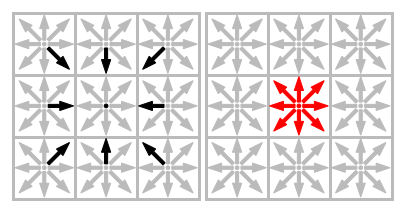

In [22]:
from lbmpy.fieldaccess import *
from lbmpy.stencils import get_stencil
from plot_setup import *
two_field = StreamPullTwoFieldsAccessor()

figsize=(7, 4)

f = plt.figure(figsize=figsize)
visualize_pdf_field_accessor(two_field, title=False, figure=f)
plt.subplots_adjust(wspace=-0.025)
write_to_file("access_stream_pull_collide")

### EsoTwist

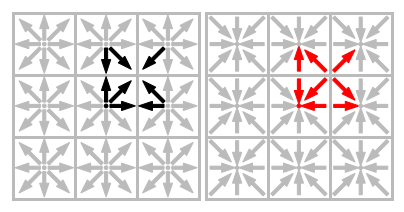

In [23]:
eso_twist_even = EsoTwistEvenTimeStepAccessor()
f = plt.figure(figsize=figsize)
visualize_pdf_field_accessor(eso_twist_even, title=False, figure=f,
                             write_plot_params={'inverted': True})
plt.subplots_adjust(wspace=-0.025)
write_to_file("access_eso_even")

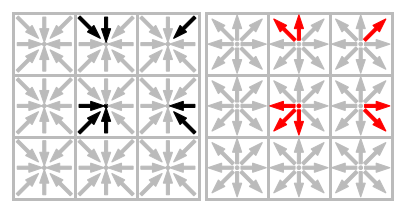

In [24]:
eso_twist_odd = EsoTwistOddTimeStepAccessor()
f = plt.figure(figsize=figsize)
visualize_pdf_field_accessor(eso_twist_odd, title=False, figure=f,
                             read_plot_params={'inverted': True})
plt.subplots_adjust(wspace=-0.025)
write_to_file("access_eso_odd")

### AA

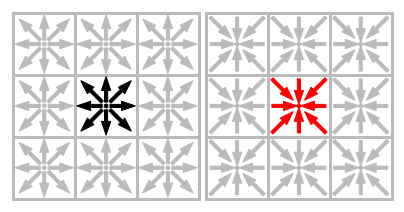

In [25]:
aa_even = AAEvenTimeStepAccessor()
f = plt.figure(figsize=figsize)
visualize_pdf_field_accessor(aa_even, title=False, figure=f,
                             write_plot_params={'inverted': True})
plt.subplots_adjust(wspace=-0.025)
write_to_file("access_aa_even")

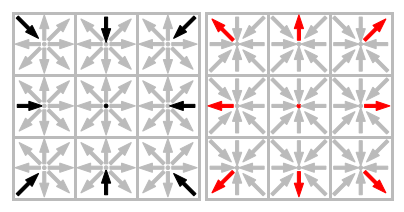

In [26]:
aa_odd = AAOddTimeStepAccessor()
f = plt.figure(figsize=figsize)
visualize_pdf_field_accessor(aa_odd, title=False, figure=f,
                             write_plot_params={'inverted': True})
plt.subplots_adjust(wspace=-0.025)
write_to_file("access_aa_odd")